# Part I. RUL prediction using Transformer model (Centralize model)

# Preparation

In [1]:
# When run code on Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
print(f'IN_COLAB: {IN_COLAB}')

IN_COLAB: False


In [2]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [3]:
# Off log duplicate messages
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

# Off warning messages
import warnings
warnings.filterwarnings('ignore')

if not IN_COLAB:
    try:
        import pyinspect as pi
    except:
        pass

In [4]:
from collections import OrderedDict
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from datasets.utils.logging import disable_progress_bar

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

import shap

2025-02-11 07:50:40,434	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/os/anaconda3/envs/.venv/lib/python3.12/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):


In [5]:
# Check GPU if available else CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.14.0 / PyTorch 2.5.1+cu124


# Building Transformer model

In [6]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)

# Building Dataloader

In [7]:
class CMAPSSLoaderDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3','Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):

        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

# Define parameters for training

In [8]:
# Transformer parameters
input_dim = 21
d_model = 64
nhead = 4
num_layers = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 1e-3
verbose=False

# Dataloader parameters
sequence_length = 30

# Training parameters
batch_size = 128
epochs = 50

# Define training/test functions

In [9]:
def train_model(model, client_loader_train, client_loader_validation: None, epochs: int, learning_rate: int, verbose=False):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(client_loader_train)}, Validation Loss: {val_loss/len(client_loader_validation)}")

In [10]:
def test_model(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for batch in client_loader_validation:
            samples, targets = batch
            samples, targets = samples.to(DEVICE), targets.to(DEVICE)
            predictions = model(samples)
            val_loss += criterion(predictions, targets).item()
    return val_loss/len(client_loader_validation)

# Define prediction functions

### Prediction on a batch

In [11]:
def predict_on_batch(model, batch_loader, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    samples, targets = batch_loader
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    loss = 0
    with torch.no_grad():
        predictions = model(samples)
    loss = criterion(predictions, targets)

    if return_actual_rul:
        samples = samples.cpu()
        targets = targets.cpu()

        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        predictions = predictions.cpu()
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return loss, actual_predictions, actual_targets

    return loss

### Prediction on a sample

# File paths

In [12]:
if not IN_COLAB:
    train_1_path = "../data/train_FD001.txt"
    test_1_path = "../data/test_FD001.txt"
    rul_1_path = "../data/RUL_FD001.txt"

    train_2_path = "../data/train_FD002.txt"
    test_2_path = "../data/test_FD002.txt"
    rul_2_path = "../data/RUL_FD002.txt"

    train_3_path = "../data/train_FD003.txt"
    test_3_path = "../data/test_FD003.txt"
    rul_3_path = "../data/RUL_FD003.txt"

    train_4_path = "../data/train_FD004.txt"
    test_4_path = "../data/test_FD004.txt"
    rul_4_path = "../data/RUL_FD004.txt"
    
elif IN_COLAB:
    train_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD001.txt"
    test_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD001.txt"
    rul_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD001.txt"

    train_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD002.txt"
    test_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD002.txt"
    rul_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD002.txt"

    train_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD003.txt"
    test_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD003.txt"
    rul_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD003.txt"

    train_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD004.txt"
    test_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD004.txt"
    rul_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD004.txt"

In [13]:
# Initialization columns
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

# Calculate RUL for FD001

### Calculate RUL for train set

In [14]:
# Load trainset
train_1 = pd.read_csv(train_1_path, sep=' ', header=None)
train_1.drop([26, 27], axis=1, inplace=True)
train_1.columns = column_names

train_1['Remaining RUL'] = ''
# train_1.head()

In [15]:
# Calculate the remaining RUL for each engine
max_cycle_1 = train_1.groupby('ID Engine').count()
for idx in range(len(train_1)):
    train_1.loc[idx, 'Remaining RUL'] = max_cycle_1.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

print(f"trainset shape: {train_1.shape}")

trainset shape: (20631, 27)


In [16]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Load RUL set

In [17]:
rul_1 = pd.read_csv(rul_1_path, sep=' ', header=None)
rul_1.drop(rul_1.columns[1], axis=1, inplace=True)
rul_1.columns = ['RUL']
print(f'RUL shape: {rul_1.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [18]:
rul_1.head()

,RUL
0,112
1,98
2,69
3,82
4,91


### Calculate RUL for test

In [19]:
# Load test set
test_1 = pd.read_csv(test_1_path, sep=' ', header=None)
test_1.drop([26, 27], axis=1, inplace=True)
test_1.columns = column_names

test_1['Remaining RUL'] = ''
# test_1.head()

In [20]:
max_cycle_test_1 = test_1.groupby('ID Engine').count()

for idx in range(len(test_1)):
    test_1.loc[idx, 'Remaining RUL'] = rul_1.loc[test_1.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_1.loc[test_1.loc[idx, 'ID Engine'], 'Cycle']
test_1['Remaining RUL'] = test_1['Remaining RUL'] - test_1['Cycle']

In [21]:
test_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


# Calculate RUL for FD002

### Calculate RUL for train set

In [22]:
# Load trainset
train_2 = pd.read_csv(train_2_path, sep=' ', header=None)
train_2.drop([26, 27], axis=1, inplace=True)
train_2.columns = column_names

train_2['Remaining RUL'] = ''
# train_2.head()

In [23]:
# Calculate the remaining RUL for each engine
max_cycle_2 = train_2.groupby('ID Engine').count()
for idx in range(len(train_2)):
    train_2.loc[idx, 'Remaining RUL'] = max_cycle_2.loc[train_2.loc[idx, 'ID Engine'], 'Cycle']
train_2['Remaining RUL'] = train_2['Remaining RUL'] - train_2['Cycle']

print(f"trainset shape: {train_2.shape}")

trainset shape: (53759, 27)


In [24]:
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


### Load RUL set

In [ ]:
rul_2 = pd.read_csv(rul_2_path, sep=' ', header=None)
rul_2.drop(rul_2.columns[1], axis=1, inplace=True)
rul_2.columns = ['RUL']
print(f'RUL shape: {rul_2.shape}')

RUL shape: (259, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [26]:
rul_2.head()

,RUL
0,18
1,79
2,106
3,110
4,15


### Calculate RUL for test

In [27]:
# Load test set
test_2 = pd.read_csv(test_2_path, sep=' ', header=None)
test_2.drop([26, 27], axis=1, inplace=True)
test_2.columns = column_names

test_2['Remaining RUL'] = ''
# test_2.head()

In [28]:
max_cycle_test_2 = test_2.groupby('ID Engine').count()

for idx in range(len(test_2)):
    test_2.loc[idx, 'Remaining RUL'] = rul_2.loc[test_2.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_2.loc[test_2.loc[idx, 'ID Engine'], 'Cycle']
test_2['Remaining RUL'] = test_2['Remaining RUL'] - test_2['Cycle']

In [29]:
test_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271


# Calculate RUL for FD003

### Calculate RUL for train set

In [30]:
# Load trainset
train_3 = pd.read_csv(train_3_path, sep=' ', header=None)
train_3.drop([26, 27], axis=1, inplace=True)
train_3.columns = column_names

train_3['Remaining RUL'] = ''
# train_3.head()

In [31]:
# Calculate the remaining RUL for each engine
max_cycle_3 = train_3.groupby('ID Engine').count()
for idx in range(len(train_3)):
    train_3.loc[idx, 'Remaining RUL'] = max_cycle_3.loc[train_3.loc[idx, 'ID Engine'], 'Cycle']
train_3['Remaining RUL'] = train_3['Remaining RUL'] - train_3['Cycle']

print(f"trainset shape: {train_3.shape}")

trainset shape: (24720, 27)


In [32]:
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


### Load RUL set

In [33]:
rul_3 = pd.read_csv(rul_3_path, sep=' ', header=None)
rul_3.drop(rul_3.columns[1], axis=1, inplace=True)
rul_3.columns = ['RUL']
print(f'RUL shape: {rul_3.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [34]:
rul_3.head()

,RUL
0,44
1,51
2,27
3,120
4,101


### Calculate RUL for test

In [35]:
# Load test set
test_3 = pd.read_csv(test_3_path, sep=' ', header=None)
test_3.drop([26, 27], axis=1, inplace=True)
test_3.columns = column_names

test_3['Remaining RUL'] = ''
# test_3.head()

In [36]:
max_cycle_test_3 = test_3.groupby('ID Engine').count()

for idx in range(len(test_3)):
    test_3.loc[idx, 'Remaining RUL'] = rul_3.loc[test_3.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_3.loc[test_3.loc[idx, 'ID Engine'], 'Cycle']
test_3['Remaining RUL'] = test_3['Remaining RUL'] - test_3['Cycle']

In [37]:
test_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,276
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,275
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,274
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,273
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,272


# Calculate RUL for FD004

### Calculate RUL for train set

In [38]:
# Load trainset
train_4 = pd.read_csv(train_4_path, sep=' ', header=None)
train_4.drop([26, 27], axis=1, inplace=True)
train_4.columns = column_names

train_4['Remaining RUL'] = ''
# train_4.head()

In [39]:
# Calculate the remaining RUL for each engine
max_cycle_4 = train_4.groupby('ID Engine').count()
for idx in range(len(train_4)):
    train_4.loc[idx, 'Remaining RUL'] = max_cycle_4.loc[train_4.loc[idx, 'ID Engine'], 'Cycle']
train_4['Remaining RUL'] = train_4['Remaining RUL'] - train_4['Cycle']

print(f"trainset shape: {train_4.shape}")

trainset shape: (61249, 27)


In [40]:
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


### Load RUL set

In [41]:
rul_4 = pd.read_csv(rul_4_path, sep=' ', header=None)
rul_4.drop(rul_4.columns[1], axis=1, inplace=True)
rul_4.columns = ['RUL']
print(f'RUL shape: {rul_4.shape}')

RUL shape: (248, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [42]:
rul_4.head()

,RUL
0,22
1,39
2,107
3,75
4,149


### Calculate RUL for test

In [43]:
# Load test set
test_4 = pd.read_csv(test_4_path, sep=' ', header=None)
test_4.drop([26, 27], axis=1, inplace=True)
test_4.columns = column_names

test_4['Remaining RUL'] = ''
# test_4.head()

In [44]:
max_cycle_test_4 = test_4.groupby('ID Engine').count()

for idx in range(len(test_4)):
    test_4.loc[idx, 'Remaining RUL'] = rul_4.loc[test_4.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_4.loc[test_4.loc[idx, 'ID Engine'], 'Cycle']
test_4['Remaining RUL'] = test_4['Remaining RUL'] - test_4['Cycle']

In [45]:
test_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247


# Plot number of sample for each dataset

In [46]:
len(train_1)

20631

In [47]:
len(train_2)

53759

In [48]:
len(train_3)

24720

In [49]:
len(train_4)

61249

In [50]:
total = len(train_1) + len(train_2) + len(train_3) + len(train_4)
total

160359

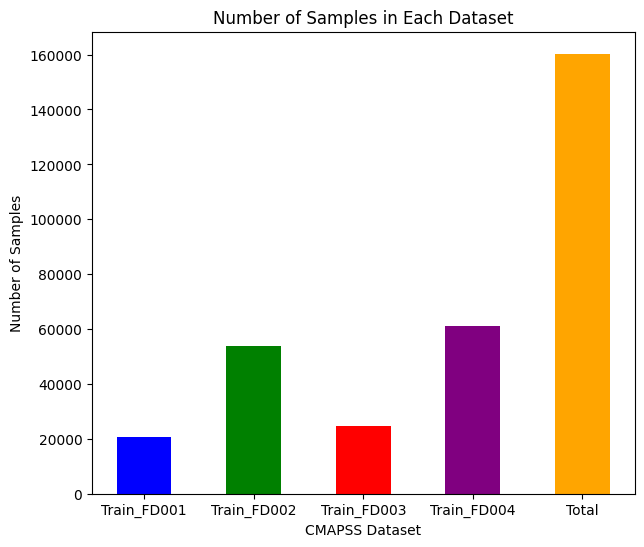

In [51]:
sample_counts = [len(train_1), len(train_2), len(train_3), len(train_4), total]
labels = ['Train_FD001', 'Train_FD002', 'Train_FD003', 'Train_FD004', 'Total']

plt.figure(figsize=(7, 6))
plt.bar(labels, sample_counts, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)
plt.xlabel('CMAPSS Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Dataset')
plt.show()

# Concatenate for train_FD001,2,3,4

In [52]:
print(f'train_1 shape: {train_1.shape}')
print(f'test_1 shape: {test_1.shape}')
print(f'rul_1 shape: {rul_1.shape}')
print(f'max_cycle_1 shape: {max_cycle_1.shape}')

train_1 shape: (20631, 27)
test_1 shape: (13096, 27)
rul_1 shape: (100, 1)
max_cycle_1 shape: (100, 26)


In [53]:
print(f'train_2 shape: {train_2.shape}')
print(f'test_2 shape: {test_2.shape}')
print(f'rul_2 shape: {rul_2.shape}')
print(f'max_cycle_2 shape: {max_cycle_2.shape}')

train_2 shape: (53759, 27)
test_2 shape: (33991, 27)
rul_2 shape: (259, 1)
max_cycle_2 shape: (260, 26)


In [54]:
print(f'train_3 shape: {train_3.shape}')
print(f'test_3 shape: {test_3.shape}')
print(f'rul_3 shape: {rul_3.shape}')
print(f'max_cycle_3 shape: {max_cycle_3.shape}')

train_3 shape: (24720, 27)
test_3 shape: (16596, 27)
rul_3 shape: (100, 1)
max_cycle_3 shape: (100, 26)


In [55]:
print(f'train_4 shape: {train_4.shape}')
print(f'test_4 shape: {test_4.shape}')
print(f'rul_4 shape: {rul_4.shape}')
print(f'max_cycle_4 shape: {max_cycle_4.shape}')

train_4 shape: (61249, 27)
test_4 shape: (41214, 27)
rul_4 shape: (248, 1)
max_cycle_4 shape: (249, 26)


In [56]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [57]:
num = len(train_1)
for idx in range(len(train_2)):
    train_2.loc[idx, 'ID Engine'] += num
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,20632,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,20632,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,20632,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,20632,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,20632,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [58]:
num += len(train_2)
for idx in range(len(train_3)):
    train_3.loc[idx, 'ID Engine'] += num
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,74391,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,74391,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,74391,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,74391,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,74391,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [59]:
num += len(train_3)
for idx in range(len(train_4)):
    train_4.loc[idx, 'ID Engine'] += num
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,99111,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,99111,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,99111,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,99111,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,99111,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [60]:
train = pd.concat([train_1, train_2, train_3, train_4], ignore_index=True)
print(f'Train shape: {train.shape}')
train.head()

Train shape: (160359, 27)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


# Standard data (for train and test set)

In [61]:
scaled_columns = train.columns[5:]
scaler = MinMaxScaler()
train[scaled_columns] = scaler.fit_transform(train[scaled_columns])
# test[scaled_columns] = scaler.fit_transform(test[scaled_columns])

In [62]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,1.0,0.969990,0.927293,0.902111,1.0,...,0.993194,0.653748,0.090428,1.0,0.918367,1.0,1.0,0.972082,0.970373,0.352399
1,1,2,0.0019,-0.0003,100.0,1.0,0.973000,0.932957,0.908192,1.0,...,0.993332,0.637831,0.094654,1.0,0.918367,1.0,1.0,0.970064,0.970630,0.350554
2,1,3,-0.0043,0.0003,100.0,1.0,0.974824,0.922723,0.910730,1.0,...,0.993222,0.641715,0.089844,1.0,0.897959,1.0,1.0,0.968382,0.966204,0.348708
3,1,4,0.0007,0.0000,100.0,1.0,0.974824,0.908829,0.905152,1.0,...,0.993359,0.643055,0.072803,1.0,0.918367,1.0,1.0,0.966028,0.967860,0.346863
4,1,5,-0.0019,-0.0002,100.0,1.0,0.975007,0.908989,0.915565,1.0,...,0.993249,0.642988,0.093829,1.0,0.928571,1.0,1.0,0.966700,0.969560,0.345018


In [63]:
# test.head()

# Training with sequence_length = 10

### Load data into DataLoader

In [64]:
data_train = CMAPSSLoaderDataset(data=train, sequence_length=10)
# data_test = CMAPSSLoaderDataset(data=test, sequence_length=sequence_length)

data_train, data_validation = train_test_split(data_train, test_size=0.2, random_state=42)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(data_validation, batch_size=batch_size, shuffle=True)

### Training centralize model

In [65]:
centralize_transformer_model = TransformerModel(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=256,
    dropout=dropout
)

In [66]:
try:
    train_model(
        model=centralize_transformer_model,
        client_loader_train=train_loader,
        client_loader_validation=validation_loader,
        epochs=epochs,
        learning_rate=learning_rate,
        verbose=False
    )
except KeyboardInterrupt:
    print("Training interrupted")

Epoch 1/50, Train Loss: 0.027627216976983154, Validation Loss: 0.019120500229793714
Epoch 2/50, Train Loss: 0.013043094427844168, Validation Loss: 0.010503882735472992
Epoch 3/50, Train Loss: 0.011096733565193717, Validation Loss: 0.010765963249464995
Epoch 4/50, Train Loss: 0.010708940506023997, Validation Loss: 0.010371129747279205
Epoch 5/50, Train Loss: 0.010540974971491104, Validation Loss: 0.01002859132928596
Epoch 6/50, Train Loss: 0.01041533552914827, Validation Loss: 0.009850634756610107
Epoch 7/50, Train Loss: 0.010391288174863669, Validation Loss: 0.009941335296049653
Epoch 8/50, Train Loss: 0.01039560930609997, Validation Loss: 0.010256370859939403
Epoch 9/50, Train Loss: 0.010284886391289912, Validation Loss: 0.009939460404588226
Epoch 10/50, Train Loss: 0.010190310094482338, Validation Loss: 0.010253515096450866
Epoch 11/50, Train Loss: 0.01017465612581261, Validation Loss: 0.009874671430972355
Epoch 12/50, Train Loss: 0.010137688746697125, Validation Loss: 0.009818795166

### Predic on batch

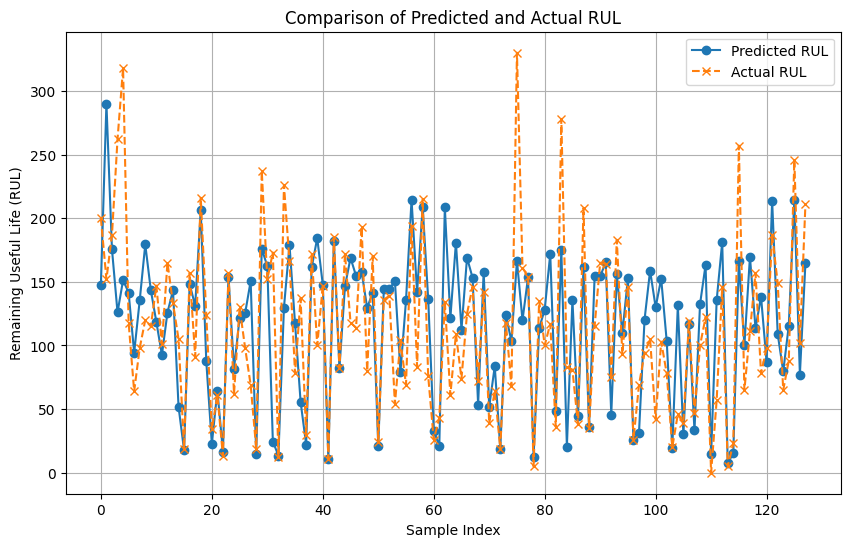

Loss on random batch: 0.008260447531938553


In [67]:
batch_loader = next(iter(validation_loader))

loss, _, _ = predict_on_batch(
    model=centralize_transformer_model,
    batch_loader=batch_loader,
    return_actual_rul=True,
    show_fig=True,
)
print(f'Loss on random batch: {loss}')

# Part II. Explainable Artificial Intelligence for RUL forecasting using Transformer model

# Part III. Setup Federated Learning with Flower for RUL prediction using Transformer model

### Define parameters for training FL with Flower

In [68]:
num_clients = 10
num_rounds = 50

### Split dataframe to 10 subframe for 10 client

In [69]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

In [70]:
# train.head()
train.shape

(160359, 27)

In [71]:
data = CMAPSSLoaderDataset(train, sequence_length=sequence_length)
train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)

subset_trains = split_dataset(train_data, num_clients=num_clients)
subset_validations = split_dataset(validation_data, num_clients=num_clients)

client_loader_trains = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_trains]
client_loader_validations = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_validations]

In [72]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 11183 samples
Client 2 will use a subset with 11183 samples
Client 3 will use a subset with 11183 samples
Client 4 will use a subset with 11183 samples
Client 5 will use a subset with 11183 samples
Client 6 will use a subset with 11183 samples
Client 7 will use a subset with 11183 samples
Client 8 will use a subset with 11183 samples
Client 9 will use a subset with 11183 samples
Client 10 will use a subset with 11191 samples


In [73]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 11183 samples
Client 2 will use a subset with 11183 samples
Client 3 will use a subset with 11183 samples
Client 4 will use a subset with 11183 samples
Client 5 will use a subset with 11183 samples
Client 6 will use a subset with 11183 samples
Client 7 will use a subset with 11183 samples
Client 8 will use a subset with 11183 samples
Client 9 will use a subset with 11183 samples
Client 10 will use a subset with 11191 samples


### Update model parameters

In [74]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

### Define the Flower ClientApp

In [75]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train_model(
            model=self.model,
            client_loader_train=self.trainloader,
            client_loader_validation=self.valloader,
            epochs=1,
            learning_rate=learning_rate,
            verbose=False
        )
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test_model(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [76]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    model = TransformerModel(
        input_dim=input_dim,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=0.1
    ).to(DEVICE)

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

### Define the Flower ServerApp

In [77]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [78]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=50)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

### Run the training

In [79]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [80]:
try:
    # Run simulation
    run_simulation(
        server_app=server,
        client_app=client,
        num_supernodes=num_clients,
        backend_config=backend_config
    )
except KeyboardInterrupt:
    print("Simulation interrupted by user.")

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0970639489506456, Validation Loss: 0.020048649473623795
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.09441370025954464, Validation Loss: 0.020601569844240494
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.08046383391642435, Validation Loss: 0.019045989664102144
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.09806777234189212, Validation Loss: 0.01919098168780858
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.10201417235657573, Validation Loss: 0.022912030192938717
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.1007404336917468, Validation Loss: 0.021249166097153317
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0993254197634418, Validation Loss: 0.020795028064061295
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.10287207591516728, Validation Loss: 0.02193527880378745
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.09457410632802005, Validation Loss: 0.021277598571032286


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.10107315060767261, Validation Loss: 0.021625103005631405


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.030504558044909078, Validation Loss: 0.019577499225058338
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.030862843956459652, Validation Loss: 0.020559764467179775
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.027196958174251697, Validation Loss: 0.019435320980846882
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02970899399158291, Validation Loss: 0.019219618375328453
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.028086883015930653, Validation Loss: 0.023317732848227024
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.03036007558164949, Validation Loss: 0.02069373894482851
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.029558744345029645, Validation Loss: 0.020687267861583016
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.030956771880896253, Validation Loss: 0.02131263983689926
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.028842905345796185, Validation Loss: 0.021166901019486515


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.029022052481939845, Validation Loss: 0.019959105305712332


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02489438389470293, Validation Loss: 0.019764623350717804
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.023621062060225417, Validation Loss: 0.020274214700541714
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02422476215923036, Validation Loss: 0.01899869731542739
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.024490186870521444, Validation Loss: 0.019329595210200005
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.023327738914469428, Validation Loss: 0.022942648904228754
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02401739354668693, Validation Loss: 0.020629439672285862
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.023638062835247678, Validation Loss: 0.020721686665307392
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02320388446307995, Validation Loss: 0.021344661797312172
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.023549663400362162, Validation Loss: 0.021132993511855602


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02440742835063826, Validation Loss: 0.019458398984914475


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.022322840586473994, Validation Loss: 0.019594262311743063
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.021881200436672025, Validation Loss: 0.020403974943540314
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.022699835286899048, Validation Loss: 0.019068799404935402
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.022711750532669776, Validation Loss: 0.019986543719741432
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.021809712369841607, Validation Loss: 0.022805358875881542
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02340679846450009, Validation Loss: 0.020831088789484718
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.022173768618482758, Validation Loss: 0.020752364430915226
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.022803727727891368, Validation Loss: 0.02159296568821777
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.022009154040874404, Validation Loss: 0.021538982591168446


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02179681162603877, Validation Loss: 0.019948742775754494


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.021633695557036182, Validation Loss: 0.019495121203362942
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.021044783770445396, Validation Loss: 0.02186677105386149
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.021469142129221422, Validation Loss: 0.018934748812832615
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02174081189811907, Validation Loss: 0.019026484509760685
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02135538193397224, Validation Loss: 0.02303427788005634
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.021946129960600625, Validation Loss: 0.02080213384364139
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.021365602204406805, Validation Loss: 0.021260460500012745
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02243183017708361, Validation Loss: 0.022838174873455006
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.021211578510701656, Validation Loss: 0.020806547127325426


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.02166564304339276, Validation Loss: 0.019447595389051872


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.018913465403867038, Validation Loss: 0.014892951924015175
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01906713321593336, Validation Loss: 0.013303936205127022
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01883899463890967, Validation Loss: 0.01282334988090125
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01970810837916691, Validation Loss: 0.015484739772298119
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.019870468171906065, Validation Loss: 0.015535582195628773
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.020321927477859637, Validation Loss: 0.0195432628758929
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.020094932564957577, Validation Loss: 0.017994959373027086
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.019479965029115028, Validation Loss: 0.017745990517803213
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01838394831231033, Validation Loss: 0.01385923915288665


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.020149539965628224, Validation Loss: 0.0165042510594834


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.015280613337050785, Validation Loss: 0.011238160479644483
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.014987823870879683, Validation Loss: 0.012634120500561867
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.013919195657680657, Validation Loss: 0.010593329937281933
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.014424529794434255, Validation Loss: 0.01150161349637942
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01455465163400566, Validation Loss: 0.013423992786556482
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0186764171495187, Validation Loss: 0.014302172020755032
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.014102206131528046, Validation Loss: 0.011442016725513067
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.013739615837535397, Validation Loss: 0.011056831064210697
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01382264593319798, Validation Loss: 0.013944732448594137


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.014278066566806625, Validation Loss: 0.01063372948291627


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.013369963567873294, Validation Loss: 0.010596116073429585
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012910466874018312, Validation Loss: 0.010398509869859978
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012216112348886038, Validation Loss: 0.008313494205305522
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012525315819816156, Validation Loss: 0.008745553077791225
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012813056861473755, Validation Loss: 0.011216219937936827
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012477591549131003, Validation Loss: 0.0099949747831984
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012694712029770017, Validation Loss: 0.009600954257290472
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012367339825934985, Validation Loss: 0.010502119463953104
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012365287053398788, Validation Loss: 0.009719930462200533


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012450167411853645, Validation Loss: 0.009668735893104564


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011442795840346, Validation Loss: 0.009147579506547614
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011365122246471319, Validation Loss: 0.010061671258881688
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011338838407854464, Validation Loss: 0.008539218032224611
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011601394523908808, Validation Loss: 0.008995634778826074
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011379887931980193, Validation Loss: 0.010980751852250913
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.012005583076229826, Validation Loss: 0.008916454897685484
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011294541404243897, Validation Loss: 0.009637707780877297
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010805098657411609, Validation Loss: 0.010887942446226423
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01072980780471963, Validation Loss: 0.009951572420752862


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011679304488511249, Validation Loss: 0.009144318565218286


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011094774585217237, Validation Loss: 0.009339594218710607
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010964811784850264, Validation Loss: 0.009105240333486687
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010653747102796015, Validation Loss: 0.008836994180455804
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010827068324116144, Validation Loss: 0.008354800118302757
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011148410732857883, Validation Loss: 0.011270256501368502
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010916695136322895, Validation Loss: 0.00893163380467079
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01113462933360345, Validation Loss: 0.009237116054547105
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010690320108551532, Validation Loss: 0.00908857230520384
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010297008668368851, Validation Loss: 0.010673307348042727


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011117566921959886, Validation Loss: 0.009372766172005371


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010891376925759356, Validation Loss: 0.008771457455374977
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010777320987968282, Validation Loss: 0.008946959140964529
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010615508373699744, Validation Loss: 0.008980655238371004
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010938254470767622, Validation Loss: 0.010405147151852196
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.011523635835725476, Validation Loss: 0.010377510493113236
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010563237851866606, Validation Loss: 0.009596115909516811
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010484950124836441, Validation Loss: 0.009748980148949406
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010648399437989363, Validation Loss: 0.009195985590023074
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010350047092122788, Validation Loss: 0.009389057374474678


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010642481549769978, Validation Loss: 0.009338114770467986


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010834989190863615, Validation Loss: 0.00890606550753794
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010058246521194551, Validation Loss: 0.00903754753314636
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010316213682844218, Validation Loss: 0.008519996698437766
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01056708010781387, Validation Loss: 0.008465072076598351
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010788595949468965, Validation Loss: 0.010856999740512534
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010731762222183699, Validation Loss: 0.009046623229303143
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010411681824321435, Validation Loss: 0.010252368572930043
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010375314963642846, Validation Loss: 0.010021674912422895
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00972421726592901, Validation Loss: 0.009766188407824799


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010511026765346865, Validation Loss: 0.009037063393572515


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010738141078036278, Validation Loss: 0.00882320169528777
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01008129616754807, Validation Loss: 0.009244804503396153
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010653293839740481, Validation Loss: 0.008479387330060656
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010550588110080835, Validation Loss: 0.00898249923590232
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010404845821374858, Validation Loss: 0.010530002118850296
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010325684937098149, Validation Loss: 0.009102348005399108
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010379190853034908, Validation Loss: 0.009525682057508013
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009962584071961994, Validation Loss: 0.009401646971871907
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010739412523848428, Validation Loss: 0.00922092890620909


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01054980235957456, Validation Loss: 0.008784994758157567


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010248238855803555, Validation Loss: 0.008443589512766763
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010196102677251805, Validation Loss: 0.010980188423259691
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010226631145501002, Validation Loss: 0.008681101534007625
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010122533559545198, Validation Loss: 0.00867871804670854
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010340320121031255, Validation Loss: 0.010400297607041219
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010138912200504406, Validation Loss: 0.008817746092311361
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010096989238677039, Validation Loss: 0.009358896514062177
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009896353125275875, Validation Loss: 0.01080244288525798
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010430973811625418, Validation Loss: 0.00918435754085129


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010277888642370024, Validation Loss: 0.009351176061582837


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010445226327812468, Validation Loss: 0.008966291005807843
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010132673921444539, Validation Loss: 0.008643545718355612
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009972356545569544, Validation Loss: 0.007968152217058972
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010187734992624346, Validation Loss: 0.008315373720093206
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010129174799658358, Validation Loss: 0.01028029783628881
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010127792600542307, Validation Loss: 0.009023768446323547
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01001079104819589, Validation Loss: 0.008985016537322239
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009766250330192799, Validation Loss: 0.009282001505859873
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009509668050503189, Validation Loss: 0.009471709924665365


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010224697862709449, Validation Loss: 0.008593270385807211


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010122299014421349, Validation Loss: 0.00864779491993514
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009872432660565457, Validation Loss: 0.008923799709670922
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010132448118053038, Validation Loss: 0.00795359522188929
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010102975695520978, Validation Loss: 0.008306985890323465
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010191438047596339, Validation Loss: 0.009931372859599915
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010206036470745776, Validation Loss: 0.008800089570947668
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009863034896129235, Validation Loss: 0.009132063418457454
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00976502490547401, Validation Loss: 0.00982735568488186
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009528245612851937, Validation Loss: 0.009100902825593948


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009977444096214393, Validation Loss: 0.008671775671907446


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010015372589061206, Validation Loss: 0.008664100028743798
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009830582357773726, Validation Loss: 0.009105402023785493
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009705232609783045, Validation Loss: 0.008127762766724283
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009966033426198092, Validation Loss: 0.00907555374909531
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010086418663955887, Validation Loss: 0.010170004902068864
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00977044133998623, Validation Loss: 0.00902990967204625
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009756029668179426, Validation Loss: 0.00903492776507681
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009593728739260272, Validation Loss: 0.009378074223852971
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009578347259031778, Validation Loss: 0.009191653394902294


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009759570583066141, Validation Loss: 0.009028996933590282


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010118164360226894, Validation Loss: 0.010288883169943636
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00984694913495332, Validation Loss: 0.008769766342910853
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009585151226598431, Validation Loss: 0.0077829613054001875
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010233282508455555, Validation Loss: 0.008755396183749492
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009912657826630906, Validation Loss: 0.010080611121586779
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009944878788453272, Validation Loss: 0.009516673945737157
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00974856278414584, Validation Loss: 0.009300899480215528
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009503900988916443, Validation Loss: 0.009052344746041026
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009432974774178794, Validation Loss: 0.009157955561849203


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.01000710641859438, Validation Loss: 0.009001039963384921


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00985511079621078, Validation Loss: 0.008822862058877945
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009723173083991489, Validation Loss: 0.009588498897342519
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009814437431156297, Validation Loss: 0.007763017730956728
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009834227321500128, Validation Loss: 0.008815840373493054
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010071711545937102, Validation Loss: 0.010591096456416628
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010053740211085162, Validation Loss: 0.009313348257406191
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00963581771462817, Validation Loss: 0.009325739250264385
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009537464441646907, Validation Loss: 0.009395026369020343
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009237365088086914, Validation Loss: 0.009408229940824887


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009970523533411324, Validation Loss: 0.008320745059543035


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009825673134235496, Validation Loss: 0.009152254005047407
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009904708877332847, Validation Loss: 0.008791325486857782
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009713569857095454, Validation Loss: 0.008141515967012807
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009768687532579695, Validation Loss: 0.008986221541735258
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009983797314238142, Validation Loss: 0.011197306829589334
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009963927981020375, Validation Loss: 0.009697259615429422
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009538727219809185, Validation Loss: 0.009477080480957573
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009312316426075995, Validation Loss: 0.009081039535389706
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00952902859055691, Validation Loss: 0.009872115555812012


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009785635714334521, Validation Loss: 0.00807298639450561


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00996742050417445, Validation Loss: 0.0085085302548991
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009329750414260408, Validation Loss: 0.008704538054933602
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009426189988682216, Validation Loss: 0.007688957647505132
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00974234904226085, Validation Loss: 0.008950925029983575
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009692915440113707, Validation Loss: 0.010112784316085956
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00994566429025409, Validation Loss: 0.009554174919189378
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009424265950325538, Validation Loss: 0.008997619406066158
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009400470944290812, Validation Loss: 0.008897908603433858
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009357138013001531, Validation Loss: 0.0093212810090997


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009608133193317124, Validation Loss: 0.00829352294518189


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009840623099907216, Validation Loss: 0.00867773076011376
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0093740373109044, Validation Loss: 0.00926308778368614
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009539660987105559, Validation Loss: 0.007835629988800396
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009821707308715717, Validation Loss: 0.008387139977209947
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009846604942471127, Validation Loss: 0.010172363920983944
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009884912711144849, Validation Loss: 0.008806273425844583
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009695353303951297, Validation Loss: 0.009809564883736048
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009240398135840554, Validation Loss: 0.010778194970705292
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009151148847939277, Validation Loss: 0.009585094744000922


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009728589015801183, Validation Loss: 0.008454284546050158


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009829560469370335, Validation Loss: 0.009968231432139874
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009542098607529293, Validation Loss: 0.013476000633090734
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009533882352777502, Validation Loss: 0.008065646471963688
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009642770185812631, Validation Loss: 0.008523021972822871
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010038754347161475, Validation Loss: 0.010173461950299416
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009581386048177426, Validation Loss: 0.008738916769454425
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009508710095277902, Validation Loss: 0.009345749350772663
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009407867322972214, Validation Loss: 0.010506678457287226
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009307216667697172, Validation Loss: 0.00895917538384145


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00968948468322527, Validation Loss: 0.008157341211864894


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009712748356502165, Validation Loss: 0.008689726364206184
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00956527875545858, Validation Loss: 0.008610932156443596
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009513651645234362, Validation Loss: 0.008375901813534174
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009857311326248402, Validation Loss: 0.00832976112988862
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009748346812557429, Validation Loss: 0.00986445868726481
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00966741288059645, Validation Loss: 0.008691254389387641
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009464823577383702, Validation Loss: 0.008842610330744223
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009174838757396421, Validation Loss: 0.009276226755570282
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009345308671155099, Validation Loss: 0.00923803537576036


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009702222564638678, Validation Loss: 0.008860250723294237


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009817566542716866, Validation Loss: 0.008412471506744623
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009706863392652436, Validation Loss: 0.008873794122006406
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009496659987648442, Validation Loss: 0.008214993910356001
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009789804128972306, Validation Loss: 0.008220972112295303
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009589787969492714, Validation Loss: 0.011239089537411928
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009629312680441548, Validation Loss: 0.008503873239864002
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009422781004104763, Validation Loss: 0.008694022449410775
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009163557207846845, Validation Loss: 0.009331386642191897
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009119100556497207, Validation Loss: 0.009128828829323704


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00974547607951205, Validation Loss: 0.008281726559454744


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00960085978625681, Validation Loss: 0.00865837048993192
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009347875401462343, Validation Loss: 0.009619145442477682
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009315534293736246, Validation Loss: 0.007905900732360104
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009428418421355838, Validation Loss: 0.00823192573575811
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009588704269845039, Validation Loss: 0.010147614531557669
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009591749133753845, Validation Loss: 0.008661738300526684
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009280202926178887, Validation Loss: 0.008687923514199529
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009139635679523715, Validation Loss: 0.008887909141115168
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009118113920769909, Validation Loss: 0.008925664048133925


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009480577533725987, Validation Loss: 0.008878819475119764


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009592817339580506, Validation Loss: 0.00879313828508285
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009195326086641713, Validation Loss: 0.009188489057123661
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009506601618010212, Validation Loss: 0.007894090800122782
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009507096626541832, Validation Loss: 0.009274596348404884
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009894350945780223, Validation Loss: 0.009975664635104213
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00961959614968774, Validation Loss: 0.008698000297458335
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009663632658140903, Validation Loss: 0.008657262025570328
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008994649846995757, Validation Loss: 0.009307333310558037
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008975973712619056, Validation Loss: 0.009109210519289429


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009619908248582347, Validation Loss: 0.008741404480216179


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009590015032286332, Validation Loss: 0.008997659939764575
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009348180753559891, Validation Loss: 0.008705017918890173
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009318309952504933, Validation Loss: 0.008541603361002424
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009826787329405885, Validation Loss: 0.008329599354924127
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00979536507194015, Validation Loss: 0.009930723770098253
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009517117683902721, Validation Loss: 0.008834825341843745
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009176612212534317, Validation Loss: 0.00857062661089003
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009085460682399571, Validation Loss: 0.009386022892695937
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009113154871473935, Validation Loss: 0.00956754964268343


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009368544613773172, Validation Loss: 0.00898880924267525


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009558327480176971, Validation Loss: 0.009002657861194828
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009301325819582085, Validation Loss: 0.009246431693265384
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009627995822070674, Validation Loss: 0.007650605381720446
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009675218924795363, Validation Loss: 0.00822101067751646
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009507058569314804, Validation Loss: 0.010051022453064268
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00961919214089655, Validation Loss: 0.008655500979247418
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009331613577986982, Validation Loss: 0.009387481809509072
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009150563247120854, Validation Loss: 0.009418708526275375
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00910422428701581, Validation Loss: 0.009302702499553561


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009373224589084699, Validation Loss: 0.008327956247905438


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0096824540365064, Validation Loss: 0.008309320906515826
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00933908520329913, Validation Loss: 0.008480090880766511
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00953923591772433, Validation Loss: 0.0076855321372435855
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009604836422526701, Validation Loss: 0.008432161549783566
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00956532103009522, Validation Loss: 0.010175414065915074
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009838200380644676, Validation Loss: 0.009242645507170395
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009208348595579579, Validation Loss: 0.009005122394724325
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009154397803782062, Validation Loss: 0.009163834218105132
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008878234165339645, Validation Loss: 0.00980813509191979


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009601385364393618, Validation Loss: 0.00821307081390511


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009680607308506627, Validation Loss: 0.008487706707621162
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009391104717823591, Validation Loss: 0.008553101236677983
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009245233800770207, Validation Loss: 0.007723055208440532
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00959478579038246, Validation Loss: 0.008524268336424773
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009620583838444541, Validation Loss: 0.011556722139093008
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009615269854707136, Validation Loss: 0.009313840292055498
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00956264696486125, Validation Loss: 0.0088805758648298
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009002912646709856, Validation Loss: 0.010114464993503961
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009354226857381449, Validation Loss: 0.008965838234871626


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009527224645187909, Validation Loss: 0.008656390498138287


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009586596136531707, Validation Loss: 0.008943031182173978
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009208838238423183, Validation Loss: 0.009386207633228465
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009363838302140886, Validation Loss: 0.008337901608849113
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009542692484418776, Validation Loss: 0.008630820401859555
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009556633520829068, Validation Loss: 0.010287750766358593
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00938165813303468, Validation Loss: 0.008737256411801685
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009292782056780363, Validation Loss: 0.00909320504235273
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009193508039143953, Validation Loss: 0.009889250070872631
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0089506053164686, Validation Loss: 0.008850206578658386


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009661521513904021, Validation Loss: 0.008060559418729761


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009501896470531145, Validation Loss: 0.008759041549637914
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009277443343307823, Validation Loss: 0.008536874528296969
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009192217845173383, Validation Loss: 0.007855596994473175
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00931789807509631, Validation Loss: 0.011565219060602512
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0096319132452746, Validation Loss: 0.009856077482585202
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009431501109661027, Validation Loss: 0.009524240412495354
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00932309797710993, Validation Loss: 0.00943920987827534
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009047523918773302, Validation Loss: 0.009119932603260333
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009056680407163432, Validation Loss: 0.009342357177626003


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009376483466687867, Validation Loss: 0.009008821650323543


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009518970386125147, Validation Loss: 0.00841642530973662
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00912106730340218, Validation Loss: 0.009065868057818576
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00935147765664045, Validation Loss: 0.007778397824784572
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009395083147947762, Validation Loss: 0.008346212392842228
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009594611209732566, Validation Loss: 0.010319899153811011
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009629375137261708, Validation Loss: 0.008682166459038854
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0093116065307351, Validation Loss: 0.009197150738063183
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009060626394454051, Validation Loss: 0.00938956039449708
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008921046704265544, Validation Loss: 0.01077465649524873


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009459934424905276, Validation Loss: 0.008736206028102473


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009382969085973773, Validation Loss: 0.008293811401182955
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009168933431448584, Validation Loss: 0.008460895327681845
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009419040727979418, Validation Loss: 0.007854493292556568
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0094297432012602, Validation Loss: 0.008127557325430891
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.010032364691141993, Validation Loss: 0.010651212100955572
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009269692712802102, Validation Loss: 0.009858918079937046
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009144492584957996, Validation Loss: 0.008795418459075418
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00896928675303405, Validation Loss: 0.00888444561595944
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008905993621076712, Validation Loss: 0.009019147202541882


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009600997722538357, Validation Loss: 0.008533633187074553


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00910700589354912, Validation Loss: 0.008729217044839805
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009374135845891115, Validation Loss: 0.00921291849491271
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009102199851027266, Validation Loss: 0.0076361291152848435
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009418758542530915, Validation Loss: 0.008017285557633097
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00972302242669023, Validation Loss: 0.0106300716500052
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009342407051008195, Validation Loss: 0.008576683022759178
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009219686066816475, Validation Loss: 0.009142158066176555
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009159348624631424, Validation Loss: 0.009418067437681284
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009014071388678118, Validation Loss: 0.008913603060963478


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009474727954842489, Validation Loss: 0.008291169006208127


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009373438269407912, Validation Loss: 0.008421457605436444
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009497524493119934, Validation Loss: 0.00863081621090797
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009109169922091744, Validation Loss: 0.007951232160187581
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00928918589224023, Validation Loss: 0.00808160633526065
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009624952826098624, Validation Loss: 0.010222523198039695
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009369306165767326, Validation Loss: 0.00871845095587725
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009285920357797295, Validation Loss: 0.00855086629532955
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009051804372575134, Validation Loss: 0.009027469585734334
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008987192461394112, Validation Loss: 0.008897734721275892


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009370232969310811, Validation Loss: 0.008129853014410897


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009399186512878672, Validation Loss: 0.00863859552720731
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009067818622993813, Validation Loss: 0.00894060720350932
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00918805657949468, Validation Loss: 0.007840406869284132
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00939579081023112, Validation Loss: 0.00802045461552387
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00945777910105376, Validation Loss: 0.010256719140505249
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.0093271599246443, Validation Loss: 0.008662376679818739
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009339000886856493, Validation Loss: 0.00880364819683812
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00889915866586803, Validation Loss: 0.008989081845026125
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008901373028162528, Validation Loss: 0.0093498094515367


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009317040708000686, Validation Loss: 0.00824867411177944


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009379715367686003, Validation Loss: 0.008825069674375382
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009289714587132701, Validation Loss: 0.00875502221540294
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00912429628343406, Validation Loss: 0.007699918213554404
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009443207749758254, Validation Loss: 0.00845429745756767
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009558170192493972, Validation Loss: 0.01022219340401617
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00931904245887629, Validation Loss: 0.008732307300140912
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009301952911879529, Validation Loss: 0.009155028012835166
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009064466803630983, Validation Loss: 0.009274373021484776
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008788508643523197, Validation Loss: 0.009197740688581358


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009387963932981207, Validation Loss: 0.00834838332693008


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00938248984113505, Validation Loss: 0.008319888729602098
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00939160231395032, Validation Loss: 0.008581398732282898
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00938402903160419, Validation Loss: 0.009111003399911251
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00938260377469388, Validation Loss: 0.007969002133573998
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009409464382439513, Validation Loss: 0.00974287649362602
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009359574829101224, Validation Loss: 0.00868047140962021
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009208429091483016, Validation Loss: 0.008727782173082232
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00892768883866004, Validation Loss: 0.009247395887293598
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009005157176447525, Validation Loss: 0.008946342605420134


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009561776125337929, Validation Loss: 0.008333634204146538


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009380162905224344, Validation Loss: 0.00837011937983334
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009223383078774945, Validation Loss: 0.008917317746884444
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009143237193877047, Validation Loss: 0.00785563179207119
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009353807688140396, Validation Loss: 0.008186683418567885
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009416951104702259, Validation Loss: 0.009843153519217263
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00963030755519867, Validation Loss: 0.00872964970767498
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00908794028642164, Validation Loss: 0.00849797631698576
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008946236709810117, Validation Loss: 0.009562630058181558
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008908029354643077, Validation Loss: 0.009656904328783805


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009387921409639106, Validation Loss: 0.008665417553856969


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009333441870033064, Validation Loss: 0.008588697401468049
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009267775029663673, Validation Loss: 0.008620274888182228
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009110171675936064, Validation Loss: 0.008008487099273638
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009406115775081244, Validation Loss: 0.008544692176986824
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009396745447619733, Validation Loss: 0.010058538056910038
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009243560817346654, Validation Loss: 0.008836456257003274
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009085472895425151, Validation Loss: 0.00852239828302779
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009180989703798497, Validation Loss: 0.008904714962806214
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008797625540120696, Validation Loss: 0.009031325324692509


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009450106960932979, Validation Loss: 0.008072477574883536


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009303125161254271, Validation Loss: 0.008572453442452983
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00920226947743107, Validation Loss: 0.008895981062034314
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008978161648635498, Validation Loss: 0.00795414368622005
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009194829786958342, Validation Loss: 0.00814492431130599
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009348802183839407, Validation Loss: 0.010043556696142663
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009285857959184796, Validation Loss: 0.008376210187138482
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009204212660816584, Validation Loss: 0.008886498293246736
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009019590268673544, Validation Loss: 0.00905138141983612
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008785480210049585, Validation Loss: 0.00904715679247271


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00930620142025873, Validation Loss: 0.008445270169018344


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009396400239149278, Validation Loss: 0.008546950359066779
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009146395493933762, Validation Loss: 0.008503789928826418
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00904033883919262, Validation Loss: 0.008056565463034944
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009232099231501872, Validation Loss: 0.008352861739695072
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009406067499763925, Validation Loss: 0.010034662502055819
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00949031507215378, Validation Loss: 0.008963558653538877
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009100488604004071, Validation Loss: 0.009109292391010305
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00908559502568096, Validation Loss: 0.00894888989966024
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008767285876357082, Validation Loss: 0.008837644476443529


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00923104342919859, Validation Loss: 0.008258160076696764


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009468432843939147, Validation Loss: 0.008396859979256988
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009079390284816989, Validation Loss: 0.008536155250939455
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009164172293491323, Validation Loss: 0.008632400284775278
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009293707727920264, Validation Loss: 0.008275023682720282
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00924020344179801, Validation Loss: 0.010089188919995318
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009351936549964275, Validation Loss: 0.00876612982458689
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009085485648194497, Validation Loss: 0.008733351228081367
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009072167364965108, Validation Loss: 0.009292719441212037
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008947794611396437, Validation Loss: 0.008936233628033237


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009213420059743592, Validation Loss: 0.00870287244800817


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00916568847076798, Validation Loss: 0.00856267838654193
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009262376962314274, Validation Loss: 0.008900212399153546
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009046252986246889, Validation Loss: 0.007715803359381177
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009345549179918387, Validation Loss: 0.008113533300770954
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009381933783350343, Validation Loss: 0.011064538816836748
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00934060289397497, Validation Loss: 0.008412012131884694
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009022160883019254, Validation Loss: 0.008518730628896843
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009000569936523045, Validation Loss: 0.008887363407252864
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009074995908039537, Validation Loss: 0.009445045460862193


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009354930286380377, Validation Loss: 0.008222659054974263


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00930843784854832, Validation Loss: 0.008619128641757097
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009381034919484095, Validation Loss: 0.008853466334668074
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00916295584862713, Validation Loss: 0.007757191165265712
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00927296911620281, Validation Loss: 0.008692274420437488
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009405840040099893, Validation Loss: 0.0113250516270372
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00948164367582649, Validation Loss: 0.008445518429983746
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009055722996973518, Validation Loss: 0.0087289571211758
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008919638279952447, Validation Loss: 0.009134747236120429
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008818565259306606, Validation Loss: 0.009109846591441468


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00926369123309004, Validation Loss: 0.008501828753982078


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009297026903368533, Validation Loss: 0.009045666507021948
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00915202566168525, Validation Loss: 0.00882537478835068
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009088196384254843, Validation Loss: 0.007742189357734539
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00940580034247515, Validation Loss: 0.007975436154414307
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00945509640521116, Validation Loss: 0.011085447029803287
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009283567159648308, Validation Loss: 0.008626292734830216
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009194179258139973, Validation Loss: 0.008645514386113395
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008985372387211431, Validation Loss: 0.009636854117905552
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00892565935977142, Validation Loss: 0.008655433818189935


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009302832583092491, Validation Loss: 0.008311261634596369


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009351330666421827, Validation Loss: 0.008432271340015259
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00919286179652607, Validation Loss: 0.008716982979835435
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00908229902217334, Validation Loss: 0.007735648150132461
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009146943180398508, Validation Loss: 0.008192079057070341
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009577298394023355, Validation Loss: 0.009869919327849691
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00927954208931293, Validation Loss: 0.009010571795939044
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009285129559099336, Validation Loss: 0.009237640812485055
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009105430471456864, Validation Loss: 0.009022106183692813
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00884458582467315, Validation Loss: 0.00878863934088837


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00917235430626368, Validation Loss: 0.00818912479603155


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00929168382638388, Validation Loss: 0.008380685848268595
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.00906026583503593, Validation Loss: 0.008648792091249064
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008923414290289988, Validation Loss: 0.00813999827104536
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009291090986649082, Validation Loss: 0.008215178015895865
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009284069237764925, Validation Loss: 0.009969548830254511
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009336586930492724, Validation Loss: 0.008708342168988152
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009217542019376362, Validation Loss: 0.009096716297790408
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008953359454277564, Validation Loss: 0.00900418387556618
(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.008730681935875591, Validation Loss: 0.009154101092876359


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=441899) Epoch 1/1, Train Loss: 0.009166456579061394, Validation Loss: 0.008156976831907576


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 13361.87s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.020537616507234898
INFO :      		round 2: 0.02012965807013891
INFO :      		round 3: 0.020102937341752378
INFO :      		round 4: 0.02049677569249814
INFO :      		round 5: 0.020171089775182983
INFO :      		round 6: 0.014296741529621862
INFO :      		round 7: 0.011069594603031873
INFO :      		round 8: 0.008644030082293532
INFO :      		round 9: 0.008901948414065622
INFO :      		round 10: 0.008690660870210691
INFO :      		round 11: 0.008383935681459578
INFO :      		round 12: 0.008359353163872252
INFO :      		round 13: 0.008685507456010039
INFO :      		round 14: 0.008250446113842454
INFO :      		round 15: 0.008614479136568579
INFO :      		round 16: 0.008764101590283893
INFO :      		round 17: 0.008440346545963125
INFO :      		round 18: 0.008618472613902254
INFO :  